## Environment and dependency setup.

This cell imports the core Python libraries used throughout the notebook (data handling, numerical computing, and plotting), configures inline Matplotlib output, and prints basic environment information such as the Python and platform versions. It also attempts to import TensorFlow and reports its version and GPU availability, with an optional (commented-out) command to install the project’s `requirements.txt` directly into the current kernel if needed.

In [1]:
import sys, os, platform, subprocess, json
from typing import Optional, Tuple
from PIL import Image
import math
from collections import Counter, defaultdict
from src.utils.plotting import visual_sanity_check
from src.utils.cls_helpers import run_training_and_eval, main
from src.utils.tests import check_image_mask_pairs, load_image_mask, load_image_mask2
from typing import Optional
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU Available:", len(tf.config.list_physical_devices("GPU")) > 0)
except Exception as e:
    print("TensorFlow not installed yet:", e)

# Optional: install repo dependencies inside this kernel (run once if needed)
#subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=False)

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.19045-SP0
TensorFlow: 2.10.0
GPU Available: True


## Configure paths & hyperparameters.

In [2]:
ROOT_DATA = "data"   # Parent folder containing your PV01/PV03/PV08 folders
SPLITS_CSV = "data/segmentation/splits.csv"
MASK_SUFFIX = "_label"                   # Change if your masks use a different suffix

# Training params
IMG_SIZE = 256
BATCH    = 8
EPOCHS   = 8
RUN_DIR  = "reports/seg_unet"           # Where training outputs will go

## Build 60/20/20 splits for segmentation

In [3]:
os.makedirs(os.path.dirname(SPLITS_CSV), exist_ok=True)

cmd = [sys.executable, "-m", "src.data_prep.make_splits",
                       "--mode", "seg",
                       "--root", ROOT_DATA,
                       "--out", SPLITS_CSV,
                       "--seg_same_dir",
                       "--mask_suffix", MASK_SUFFIX,
                       "--img_exts", ".bmp,.png,.jpg",
                       "--mask_exts", ".bmp,.png,.jpg"
      ]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done ->", SPLITS_CSV)

Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.data_prep.make_splits --mode seg --root data --out data/segmentation/splits.csv --seg_same_dir --mask_suffix _label --img_exts .bmp,.png,.jpg --mask_exts .bmp,.png,.jpg
Done -> data/segmentation/splits.csv


## Quick peek at the CSV files

In [4]:
df = pd.read_csv(SPLITS_CSV)
df.head()

,split,image_path,mask_path
0,train,data\PV08\PV08_Ground\PV08_328877_1199747.bmp,data\PV08\PV08_Ground\PV08_328877_1199747_labe...
1,train,data\seg\PV03_Rooftop\PV03_318254_1203907.bmp,data\seg\PV03_Rooftop\PV03_318254_1203907_labe...
2,train,data\PV03\PV03_Ground_Shrubwood\PV03_319271_11...,data\PV03\PV03_Ground_Shrubwood\PV03_319271_11...
3,train,data\seg\PV03_Ground_Shrubwood\PV03_319271_119...,data\seg\PV03_Ground_Shrubwood\PV03_319271_119...
4,train,data\seg\PV01_Rooftop_FlatConcrete\PV01_325192...,data\seg\PV01_Rooftop_FlatConcrete\PV01_325192...


## Quick check whether the image_path vs mask_path are aligned.

In [5]:
check_image_mask_pairs(df)

All filenames for image path and mask path pairs are aligned (similarity >= 0.60).


## Image–mask preprocessing and sanity checks.

<div align="justify">
This cell defines two helper functions, load_image_mask2 and load_image_mask, which (i) read raw image and mask files from disk, (ii) resize them to a fixed resolution, (iii) normalise image pixels to [0,1], and (iv) convert the mask to a single-channel binary panel mask using robust thresholding (with optional auto-inversion and small morphological dilation to recover tiny panels). After defining these loaders, the cell samples a small subset of training examples from df, loads each corresponding image–mask pair, and visualises them side-by-side using Matplotlib. This serves as a sanity check to ensure that the masks are correctly decoded, binarised, and aligned with their input images.
</div>

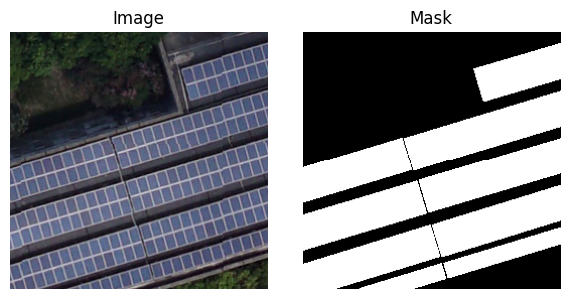

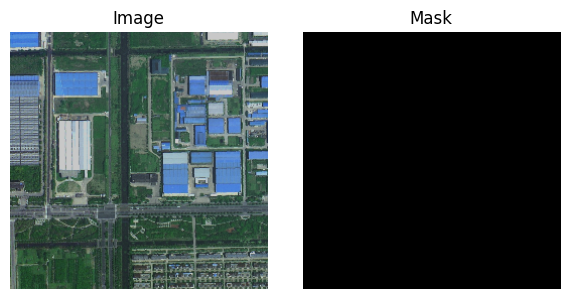

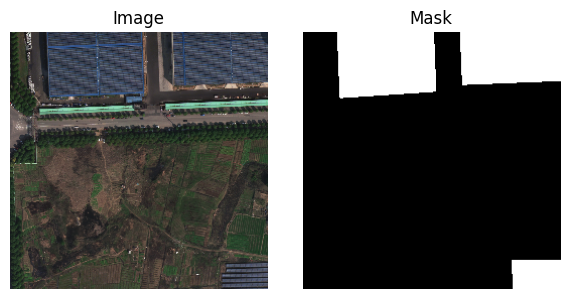

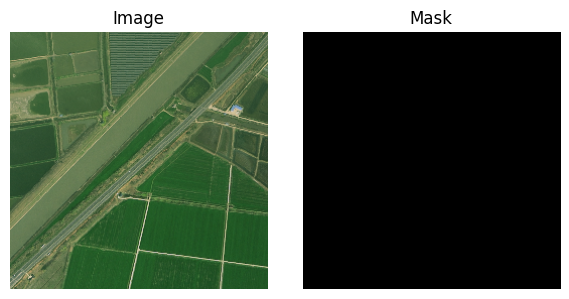

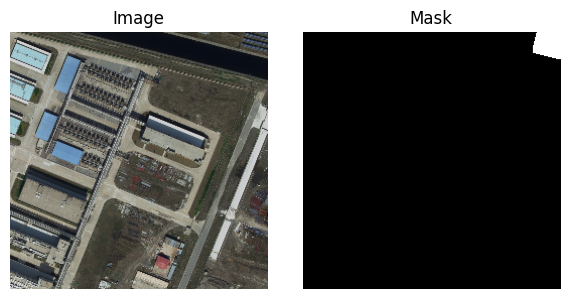

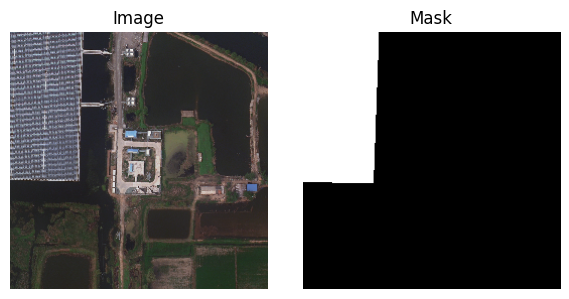

In [6]:
sub = df[df["split"]=="train"].sample(n=min(6, len(df)))
for _, r in sub.iterrows():
    img, msk = load_image_mask(r.image_path, r.mask_path, IMG_SIZE)  # returns TF tensors

    # make NumPy views for plotting
    img_np = img.numpy() if tf.is_tensor(img) else img
    # squeeze last channel ONLY if present
    if tf.is_tensor(msk) and (msk.shape.rank == 3) and (msk.shape[-1] == 1):
        msk = tf.squeeze(msk, axis=-1)
    msk_np = msk.numpy() if tf.is_tensor(msk) else msk

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(img_np); ax[0].set_title("Image"); ax[0].axis("off")
    ax[1].imshow(msk_np, cmap="gray"); ax[1].set_title("Mask"); ax[1].axis("off")
    plt.tight_layout(); plt.show()


## Train segmentation (U-Net + MobileNetV2 encoder)

<div align="justify">
This cell defines a complete training pipeline for the MobileNetV2-based U-Net segmentation model. It parses command-line arguments (paths, hyperparameters, and random seed), implements image–mask loading and binarisation, and applies simple data augmentation (random horizontal and vertical flips). A tf.data input pipeline is then constructed for the training and validation splits using the CSV file of image/mask paths. The model is instantiated via <mark>unet_mobilenetv2</mark>, compiled with an Adam optimiser, binary cross-entropy loss, and segmentation metrics <mark>(Dice coefficient, IoU)</mark>, and trained with early stopping, model checkpointing, and CSV logging. Finally, the best and last model weights are saved to the specified output directory.
</div>

In [7]:
os.makedirs(RUN_DIR, exist_ok=True)

cmd = [sys.executable, "-m", "src.seg.train_seg",
                       "--csv", SPLITS_CSV, "--out", RUN_DIR,
                       "--epochs", str(EPOCHS), "--batch", str(BATCH), "--img", str(IMG_SIZE),
      ]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Saved model & logs in:", RUN_DIR)

Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.seg.train_seg --csv data/segmentation/splits.csv --out reports/seg_unet --epochs 8 --batch 8 --img 256
Saved model & logs in: reports/seg_unet


## Plot training history

In [8]:
hist_path = os.path.join(RUN_DIR, "history.csv")
h = pd.read_csv(hist_path)
h.head(10)

,epoch,binary_accuracy,dice_coef,iou,loss,val_binary_accuracy,val_dice_coef,val_iou,val_loss
0,0,0.975641,0.096421,0.795546,0.078893,0.988614,0.131543,0.924324,0.030053
1,1,0.992864,0.139387,0.933497,0.018331,0.994399,0.140123,0.934689,0.014868
2,2,0.994458,0.145629,0.938146,0.015087,0.990420,0.129173,0.913092,0.025451
3,3,0.994289,0.144511,0.914736,0.015321,0.995598,0.145184,0.956836,0.011014
4,4,0.995211,0.147837,0.930308,0.012557,0.995769,0.147611,0.939239,0.010519
5,5,0.995700,0.150681,0.936507,0.011160,0.995922,0.148670,0.957391,0.010141
6,6,0.995806,0.151817,0.948937,0.010881,0.996082,0.148223,0.962151,0.009673
7,7,0.995213,0.150404,0.941768,0.012424,0.995983,0.148772,0.947744,0.009771


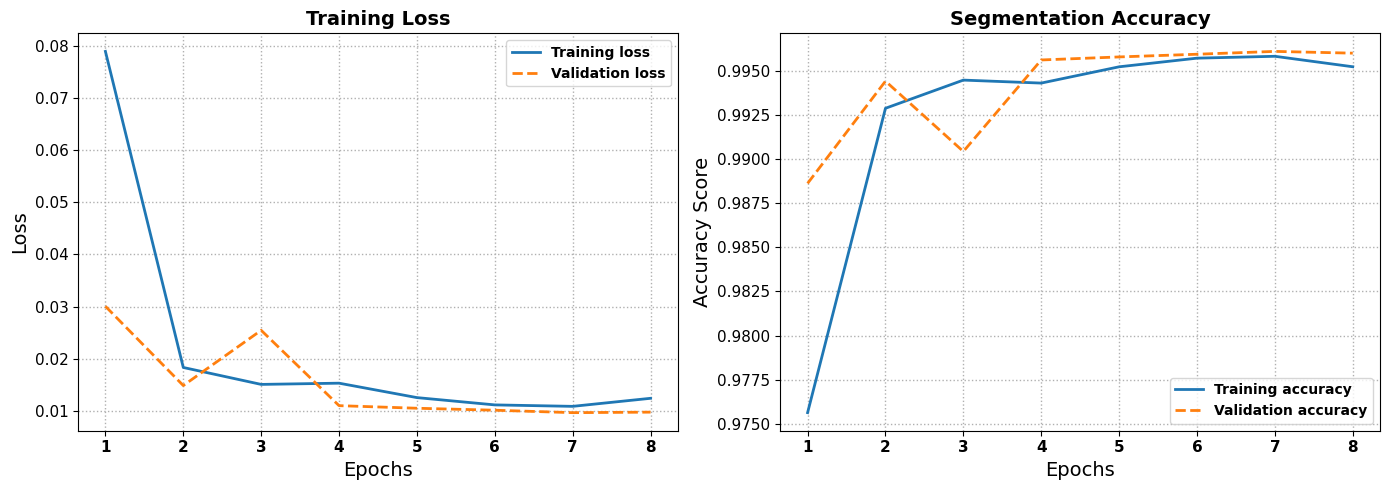

In [9]:
epoc = h['epoch'].values
epoc_range = np.arange(1, len(epoc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Loss
axes[0].plot(epoc_range, h['loss'], label='Training loss', linewidth=2.0)
axes[0].plot(epoc_range, h['val_loss'], '--', label='Validation loss', linewidth=2.0)
axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title("Training Loss", fontsize=14, fontweight='bold')
axes[0].grid(linestyle=':', linewidth=1.0)
axes[0].legend(loc='best', fontsize=10, prop={'weight':'bold'})
axes[0].set_xticks(epoc_range)
axes[0].set_xticklabels(epoc_range, fontsize=11, rotation=0, weight='bold')
axes[0].tick_params(axis='y', labelsize=11)

# Right: Accuracy
axes[1].plot(epoc_range, h['binary_accuracy'], label='Training accuracy', linewidth=2.0)
axes[1].plot(epoc_range, h['val_binary_accuracy'], '--', label='Validation accuracy', linewidth=2.0)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].set_ylabel("Accuracy Score", fontsize=14)
axes[1].set_title("Segmentation Accuracy", fontsize=14, fontweight='bold')
axes[1].grid(linestyle=':', linewidth=1.0)
axes[1].legend(loc='best', fontsize=10, prop={'weight':'bold'})
axes[1].set_xticks(epoc_range)
axes[1].set_xticklabels(epoc_range, fontsize=11, rotation=0, weight='bold')
axes[1].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

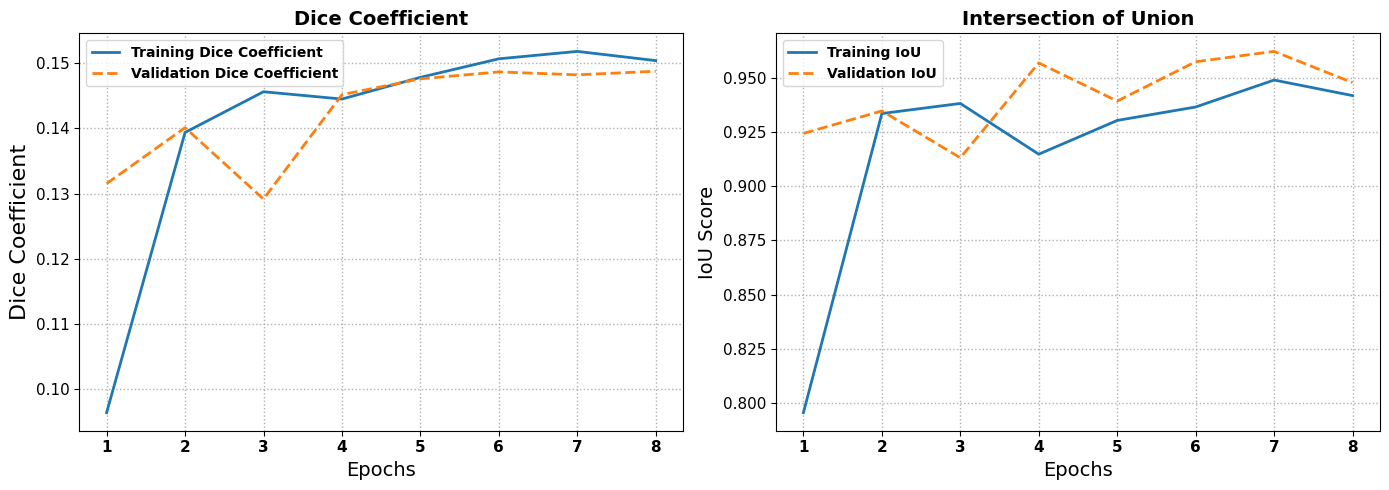

In [10]:
epoc = h['epoch'].values
epoc_range = np.arange(1, len(epoc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Loss
axes[0].plot(epoc_range,h['dice_coef'],label='Training Dice Coefficient',linewidth=2.0)
axes[0].plot(epoc_range,h['val_dice_coef'],'--',label='Validation Dice Coefficient',linewidth=2.0)
axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel('Dice Coefficient',fontsize=16)
axes[0].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[0].grid(linestyle=':', linewidth=1.0)
axes[0].legend(loc='best', fontsize=10, prop={'weight':'bold'})
axes[0].set_xticks(epoc_range)
axes[0].set_xticklabels(epoc_range, fontsize=11, rotation=0, weight='bold')
axes[0].tick_params(axis='y', labelsize=11)

# Right: Accuracy
axes[1].plot(epoc_range,h['iou'],label='Training IoU',linewidth=2.0)
axes[1].plot(epoc_range,h['val_iou'],'--',label='Validation IoU',linewidth=2.0)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].set_ylabel('IoU Score', fontsize=14)
axes[1].set_title('Intersection of Union', fontsize=14, fontweight='bold')
axes[1].grid(linestyle=':', linewidth=1.0)
axes[1].legend(loc='best', fontsize=10, prop={'weight':'bold'})
axes[1].set_xticks(epoc_range)
axes[1].set_xticklabels(epoc_range, fontsize=11, rotation=0, weight='bold')
axes[1].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

## Test-set evaluation of the segmentation model.

<div align="justify">
This cell defines a command-line evaluation script for the trained segmentation network. It parses input arguments specifying the CSV file with image/mask paths, the saved model file, the output directory, and the target image resolution. The helper function <mark>load_image_mask</mark> reads each test image and its corresponding mask, resizes them to the specified size, normalises the image to [0,1], and converts the mask to a binarised single-channel tensor. In main(), the script filters the CSV to the "test" split, loads the trained Keras model (including custom Dice and IoU metrics), and iterates over all test samples. For each case, it computes <mark>binary accuracy</mark>, <mark>Dice coefficient</mark>, and <mark>IoU</mark> between the <mark>predicted mask</mark> and <mark>ground truth</mark>, aggregates these scores over the <mark>test set</mark>, and saves the summary metrics (plus the number of test images) to <mark>test_metrics.json</mark> in the output directory, while also printing them to the console.
</div>

In [11]:
EVAL_DIR = os.path.join(RUN_DIR, "eval")
cmd = [sys.executable, "-m", "src.seg.eval_seg",
                       "--csv", SPLITS_CSV,
                       "--model", os.path.join(RUN_DIR, "best.keras"),
                       "--out", EVAL_DIR,
                       "--img", str(IMG_SIZE),
      ]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

with open(os.path.join(EVAL_DIR, "test_metrics.json"), "r") as f:
    metrics = json.load(f)
metrics

Running: c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.seg.eval_seg --csv data/segmentation/splits.csv --model reports/seg_unet\best.keras --out reports/seg_unet\eval --img 256


{'binary_accuracy': 0.9965000748634338,
 'dice': 0.14814354479312897,
 'iou': 0.963591992855072,
 'n_test': 1487}

In [12]:
TestMetrics = pd.DataFrame(metrics.values(),index=metrics.keys(),
                           columns=['value']
                          )
TestMetrics.index = ['Binary Accuracy','Dice Coefficient','Intersection of Union','Test Size']
TestMetrics

,value
Binary Accuracy,0.996500
Dice Coefficient,0.148144
Intersection of Union,0.963592
Test Size,1487.000000


## Single-Image Inference, Metrics Computation, and Visual Validation

<div align="justify">
This cell performs a quick qualitative and quantitative sanity check of the trained segmentation model on a random test example. First, the <mark>load_image_mask_bmp_safe</mark> function reads an image and its corresponding mask from disk, decodes both as 3-channel RGB (so it works reliably for BMP/PNG/JPG files), resizes them to the target resolution, normalises the image to [0,1], converts the mask to grayscale, and binarises it using a fixed threshold, returning both as NumPy arrays. The helper functions <mark>dice_np</mark> and <mark>iou_np</mark> then compute the <mark>Dice coefficient</mark> and <mark>Intersection over Union (IoU)</mark> between two binary masks by flattening them, calculating the overlap (intersection) and union, and applying the standard formulas with a small numerical stabiliser. The code loads the dataset CSV, samples a random case from the test split, and loads the corresponding image and ground-truth mask. It then loads the <mark>trained Keras model</mark>, generates a probabilistic prediction map for the mask, thresholds this map at a <mark>chosen level (THRESH) </mark> to obtain a <mark>binary predicted mask</mark>, and evaluates segmentation quality using the Dice and IoU metrics. Finally, it visualises the result in a <mark>four-panel figure</mark> showing the raw image, <mark>the ground-truth mask</mark>, <mark>the predicted probability heatmap (with colourbar)</mark>, and the <mark>binarised predicted mask</mark> annotated with the Dice and IoU scores, providing an intuitive assessment of the model's performance on an individual test sample.
</div>

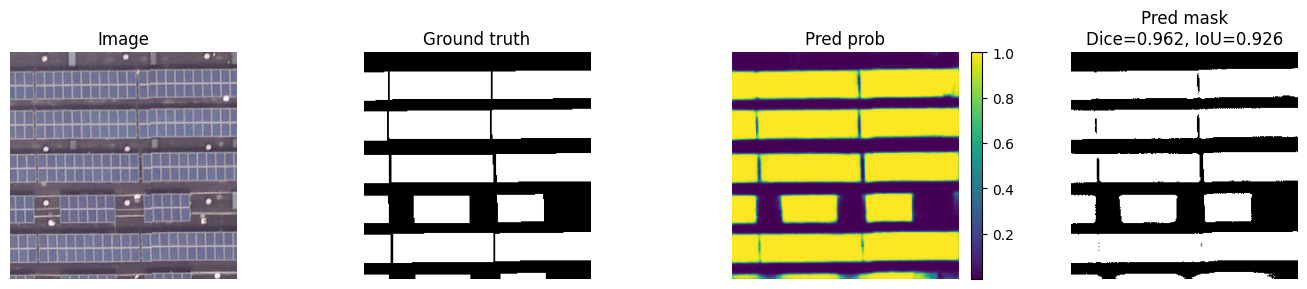

In [13]:
CSV         = "data/segmentation/splits.csv"
MODEL_PATH  = "reports/seg_unet/best.keras"   # or last.keras
IMG_SIZE    = 256                              # must match what you trained with
THRESH      = 0.5                              # binarization threshold for predictions

# --- BMP-safe loader (3-channel decode then grayscale for masks) ---
def load_image_mask_bmp_safe(img_path, msk_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # BMP-safe
    msk = tf.image.rgb_to_grayscale(msk)
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)  # binarize GT
    return img.numpy(), msk.numpy().squeeze()

def dice_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    return (2*inter + eps) / (y_true.sum() + y_pred.sum() + eps)

def iou_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    union  = y_true.sum() + y_pred.sum() - inter
    return (inter + eps) / (union + eps)

# Load a random test sample
df = pd.read_csv(CSV)
test_df = df[df["split"] == "test"]
row = test_df.sample(2).iloc[0]

img, msk_true = load_image_mask_bmp_safe(row.image_path, row.mask_path, IMG_SIZE)

# Load model (no custom objects needed for inference)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Predict
prob = model(tf.expand_dims(img, 0), training=False).numpy()[0, :, :, 0]
msk_pred = (prob >= THRESH).astype(np.float32)

# Metrics
d = dice_np(msk_true, msk_pred)
j = iou_np(msk_true, msk_pred)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].imshow(img);                  ax[0].set_title("Image");               ax[0].axis("off")
ax[1].imshow(msk_true, cmap="gray");ax[1].set_title("Ground truth");        ax[1].axis("off")
im = ax[2].imshow(prob, cmap="viridis"); ax[2].set_title("Pred prob");      ax[2].axis("off")
fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[3].imshow(msk_pred, cmap="gray"); ax[3].set_title(f"Pred mask\nDice={d:.3f}, IoU={j:.3f}"); ax[3].axis("off")
plt.tight_layout(); plt.show()


# Export the Segmentation Mask For Classification Task

In [14]:
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

try:
    from scipy import ndimage as ndi
    HAS_ND = True
except Exception:
    HAS_ND = False

print("TF:", tf.__version__, "| OpenCV:", HAS_CV2, "| SciPy.ndimage:", HAS_ND)

TF: 2.10.0 | OpenCV: False | SciPy.ndimage: True


In [15]:
CLS_CSV     = "data/classification/splits_spfnet.csv"    # The classification CSV: split,filepath,label
SEG_MODEL   = "reports/seg_unet/best.keras"               # The trained U-Net segmentation model
OUT_ROOT    = "data/classification/localized"             # where outputs go
MODE        = "both"     # "masked", "cropped", or "both"
IMG_INFER   = 256        # U-Net input size
THRESHOLD   = 0.5        # mask threshold [0..1]
THRESH_MODE = "otsu"     # 'fixed' or 'otsu' (requires OpenCV)
PAD         = 16         # pixels to pad bbox for crops
MIN_AREA    = 1500       # drop components smaller than this (in pixels)
ALPHA       = False      # masked images as RGBA (True) or black background RGB (False)
ON_EMPTY    = "copy"     # "copy", "skip", or "mask_zero" when mask is empty
EXT         = "png"      # "png" or "jpg"
DILATE_PX   = 4
CLOSE_PX    = 5
ALPHA       = False

### Image Decoding, Mask Cleanup, and Panel Crop Generation

<div align="justify">
This cell defines a set of high-quality helper functions for post-processing segmentation outputs and extracting clean image crops. It first provides a BMP-safe RGB decoder (decode_rgb) that loads images as float32 arrays in [0,1] without resizing. The <mark>letterbox</mark> and <mark>unletterbox_mask</mark> functions implement a non-distorting resize pipeline: images are resized with preserved aspect ratio, padded to a square input size for the model, and later mapped back from the square prediction to the original resolution using nearest-neighbour interpolation to keep mask edges sharp. The infer_prob_map function wraps this logic to run a U-Net–style segmentation model with letterboxing and return a full-resolution probability map. Binary masks are then obtained via threshold_prob, which supports both fixed thresholding and Otsu’s automatic threshold (with optional Gaussian pre-blur when OpenCV is available). The <mark>polish_mask</mark> function further refines binary masks by removing small connected components, closing holes, and slightly dilating the mask to obtain smoother, safer regions for cropping. Using these masks, apply_mask can either zero out the background (hard mask), optionally adding an alpha channel, or apply a soft, sigmoid-based blending for smoother edges. The <mark>bbox_from_mask</mark> and <mark>crop_panel</mark> functions compute either axis-aligned or, when <mark>OpenCV</mark> is present, rotated crops around the masked region using minAreaRect and perspective warping, producing tighter and visually sharper panel extractions. Finally, <mark>save_image</mark> saves the resulting PIL images to disk with sensible high-quality defaults for JPEG (quality, subsampling) and PNG (lossless compression).
</div>

In [16]:
def decode_rgb(img_path: str) -> np.ndarray:
    """BMP-safe decode to float32 [0,1], no resize."""
    b = tf.io.read_file(img_path)
    x = tf.image.decode_image(b, channels=3, expand_animations=False)
    return (tf.cast(x, tf.float32) / 255.0).numpy()

def infer_mask(seg_model, img_rgb01: np.ndarray, img_infer: int) -> np.ndarray:
    """Run U-Net on resized image and return probability mask resized back to original size."""
    H, W, _ = img_rgb01.shape
    x = tf.image.resize(img_rgb01, (img_infer, img_infer))
    prob = seg_model(tf.expand_dims(x, 0), training=False).numpy()[0]
    if prob.ndim == 3:  # HxWx1
        prob = prob[..., 0]
    prob_full = tf.image.resize(prob[..., None], (H, W), method="nearest").numpy()[..., 0]
    return prob_full  # float32 [0..1]

def postprocess_mask(prob_map: np.ndarray, thr: float, min_area: int) -> np.ndarray:
    """Threshold + remove tiny blobs + light closing. Return uint8 mask {0,255}."""
    m = (prob_map >= thr).astype(np.uint8)

    if min_area > 0:
        if HAS_CV2:
            n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
            keep = np.zeros_like(m)
            for i in range(1, n):
                if stats[i, cv2.CC_STAT_AREA] >= min_area:
                    keep[labels == i] = 1
            m = keep
        elif HAS_ND:
            lbl, n = ndi.label(m)
            sizes = ndi.sum(m, lbl, index=np.arange(1, n+1))
            keep = np.zeros_like(m)
            for i, size in enumerate(sizes, start=1):
                if size >= min_area:
                    keep[lbl == i] = 1
            m = keep
        # else: leave as-is

    if HAS_CV2:
        kernel = np.ones((5,5), np.uint8)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)

    return (m * 255).astype(np.uint8)


# ---------- Letterbox (no stretching) ----------
def letterbox(img01: np.ndarray, size: int, pad_val: float = 0.0):
    """Resize with preserved aspect, pad to (size,size). Returns img_sq, scale, (pad_y, pad_x)."""
    H, W, _ = img01.shape
    s = min(size / H, size / W)
    newH, newW = int(round(H * s)), int(round(W * s))
    img_res = tf.image.resize(img01, (newH, newW), method="bilinear").numpy()
    pad_y = size - newH
    pad_x = size - newW
    top = pad_y // 2
    left = pad_x // 2
    img_sq = np.ones((size, size, 3), dtype=np.float32) * pad_val
    img_sq[top:top+newH, left:left+newW] = img_res
    return img_sq, s, (top, left), (newH, newW)

def unletterbox_mask(mask_sq: np.ndarray, orig_shape: Tuple[int,int], scale: float, pad: Tuple[int,int], newHW: Tuple[int,int]):
    """Map square mask back to original HxW; trims padding, then resizes back with nearest."""
    H0, W0 = orig_shape
    top, left = pad
    newH, newW = newHW
    # crop out padding from the square
    crop = mask_sq[top:top+newH, left:left+newW]
    # resize back to original size (nearest to keep edges)
    mask_full = tf.image.resize(crop[..., None], (H0, W0), method="nearest").numpy()[..., 0]
    return mask_full

# ---------- Inference & post-processing ----------
def infer_prob_map(seg_model, img01: np.ndarray, img_infer: int) -> np.ndarray:
    """Run U-Net with letterbox; return float prob map at original size."""
    H0, W0, _ = img01.shape
    img_sq, scale, pad, newHW = letterbox(img01, img_infer, pad_val=0.0)
    prob_sq = seg_model(tf.expand_dims(img_sq, 0), training=False).numpy()[0]
    if prob_sq.ndim == 3:
        prob_sq = prob_sq[..., 0]
    # undo letterbox
    prob = unletterbox_mask(prob_sq, (H0, W0), scale=scale, pad=pad, newHW=newHW)
    return prob  # float32 [0..1]

def threshold_prob(prob: np.ndarray, thr: float, mode: str = "fixed") -> np.ndarray:
    """Return binary mask {0,1} using fixed/otsu; optional pre-blur for smoother edges."""
    p = prob.copy()
    if HAS_CV2:
        p = cv2.GaussianBlur(p, (0,0), sigmaX=1.0)  # mild anti-alias before threshold
    if mode == "otsu" and HAS_CV2:
        # Otsu expects 8-bit
        p8 = (np.clip(p, 0, 1) * 255).astype(np.uint8)
        _, m = cv2.threshold(p8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return (m > 0).astype(np.uint8)
    # default fixed threshold
    return (p >= thr).astype(np.uint8)

def polish_mask(mbin: np.ndarray, min_area: int = 500, close_px: int = 5, dilate_px: int = 3) -> np.ndarray:
    """Remove tiny blobs, close holes, and dilate a touch for safer crops."""
    m = mbin.astype(np.uint8)
    if HAS_CV2:
        n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
        keep = np.zeros_like(m)
        for i in range(1, n):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                keep[labels == i] = 1
        m = keep
        if close_px > 0:
            k = max(1, int(close_px))
            kernel = np.ones((k, k), np.uint8)
            m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)
        if dilate_px > 0:
            k = max(1, int(dilate_px))
            kernel = np.ones((k, k), np.uint8)
            m = cv2.dilate(m, kernel, iterations=1)
    return m

# ---------- Mask application & crop ----------
def apply_mask(img01: np.ndarray, prob: np.ndarray, hard_mask: bool = True, thr: float = 0.5,
               alpha_rgba: bool = False, soft_tau: float = 0.1, soft_gamma: float = 1.0) -> Image.Image:
    """
    If hard_mask: threshold & zero background.
    Else: soft blending with mask^gamma and temperature tau (crisper yet smooth edges).
    """
    img_u8 = (np.clip(img01, 0, 1) * 255).astype(np.uint8)
    if hard_mask:
        m = (prob >= thr).astype(np.uint8)
        if alpha_rgba:
            return Image.fromarray(np.dstack([img_u8, (m*255).astype(np.uint8)]), "RGBA")
        else:
            masked = img_u8.copy()
            masked[~m.astype(bool)] = 0
            return Image.fromarray(masked, "RGB")
    # soft mask
    # temperature sharpen: sigmoid((p - thr) / tau)
    m = 1.0 / (1.0 + np.exp(-(prob - thr) / max(1e-6, soft_tau)))
    m = np.power(m, soft_gamma)
    masked = (img01 * m[..., None])
    return Image.fromarray((np.clip(masked, 0, 1) * 255).astype(np.uint8), "RGB")

def bbox_from_mask(m: np.ndarray, pad: int) -> Optional[Tuple[int,int,int,int]]:
    ys, xs = np.where(m > 0)
    if len(ys) == 0:
        return None
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    return max(0, y0 - pad), y1 + pad, max(0, x0 - pad), x1 + pad

def crop_panel(img01: np.ndarray, m: np.ndarray, pad: int, rotate: bool = True) -> Optional[Image.Image]:
    """
    Axis-aligned crop; if OpenCV is available and rotate=True, use minAreaRect
    to get a tighter, oriented crop (often looks sharper).
    """
    H, W, _ = img01.shape
    if HAS_CV2 and rotate and np.any(m):
        pts = np.column_stack(np.where(m > 0)).astype(np.int32)   # (N,2) -> (y,x)
        pts_xy = np.fliplr(pts).astype(np.float32)                # (x,y)
        rect = cv2.minAreaRect(pts_xy)
        box  = cv2.boxPoints(rect).astype(np.float32)             # 4x2
        # compute warp to upright rectangle
        w = int(rect[1][0]); h = int(rect[1][1])
        if w == 0 or h == 0:
            # fallback to axis-aligned
            bb = bbox_from_mask(m, pad)
        else:
            # destination box (upright)
            dst = np.array([[0, h-1], [0, 0], [w-1, 0], [w-1, h-1]], dtype=np.float32)
            M = cv2.getPerspectiveTransform(box, dst)
            img_u8 = (np.clip(img01, 0, 1) * 255).astype(np.uint8)
            warp = cv2.warpPerspective(img_u8, M, (w, h), flags=cv2.INTER_LANCZOS4)
            return Image.fromarray(warp, "RGB")
    # axis-aligned
    bb = bbox_from_mask(m, pad)
    if bb is None:
        return None
    y0, y1, x0, x1 = bb
    y1 = min(H, y1); x1 = min(W, x1)
    crop = (np.clip(img01[y0:y1, x0:x1], 0, 1) * 255).astype(np.uint8)
    return Image.fromarray(crop, "RGB")

# High-quality save
def save_image(pil_img: Image.Image, path: str):
    path = str(path)
    if path.lower().endswith(".jpg") or path.lower().endswith(".jpeg"):
        pil_img.save(path, quality=95, subsampling=0, optimize=True)
    else:
        pil_img.save(path, compress_level=3)  # PNG (fast, lossless)


In [17]:
# sanity check: helpers present
for _name in ["decode_rgb","infer_prob_map","threshold_prob","polish_mask","apply_mask","crop_panel","save_image"]:
    if _name not in globals():
        raise RuntimeError(f"Missing helper '{_name}'. Please run the improved helpers cell first.")

# optional progress bar
try:
    from tqdm import tqdm
    _use_tqdm = True
except Exception:
    _use_tqdm = False

# pull config (with safe defaults if not set)
CLS_CSV     = globals().get("CLS_CSV", "data/classification/splits_spfnet.csv") #
SEG_MODEL   = globals().get("SEG_MODEL", "reports/seg_unet/best.keras")
OUT_ROOT    = Path(globals().get("OUT_ROOT", "data/classification/localized"))
MODE        = globals().get("MODE", "both")            # "masked" | "cropped" | "both"

IMG_INFER   = int(globals().get("IMG_INFER", 256))
THRESHOLD   = float(globals().get("THRESHOLD", 0.5))
THRESH_MODE = globals().get("THRESH_MODE", "otsu")     # "fixed" | "otsu"
PAD         = int(globals().get("PAD", 16))
MIN_AREA    = int(globals().get("MIN_AREA", 500))
DILATE_PX   = int(globals().get("DILATE_PX", 4))
CLOSE_PX    = int(globals().get("CLOSE_PX", 5))
ALPHA       = bool(globals().get("ALPHA", False))
ON_EMPTY    = globals().get("ON_EMPTY", "copy")        # "copy" | "skip" | "mask_zero"
EXT         = globals().get("EXT", "png")              # "png" | "jpg"

# output dirs
OUT_MASKED  = OUT_ROOT / "masked"
OUT_CROPPED = OUT_ROOT / "cropped"
if MODE in ("masked", "both"):  OUT_MASKED.mkdir(parents=True, exist_ok=True)
if MODE in ("cropped", "both"): OUT_CROPPED.mkdir(parents=True, exist_ok=True)

print(f"[export] CSV={CLS_CSV}")
print(f"[export] SEG_MODEL={SEG_MODEL}")
print(f"[export] OUT_ROOT={OUT_ROOT}  MODE={MODE}")
print(f"[export] INFER={IMG_INFER}  THRESH={THRESHOLD} ({THRESH_MODE})  PAD={PAD}  MIN_AREA={MIN_AREA}  DILATE={DILATE_PX}  CLOSE={CLOSE_PX}")

# load model
seg_model = tf.keras.models.load_model(SEG_MODEL, compile=False)

# read CSV (expects: split, filepath, label)
try:
    df = pd.read_csv(CLS_CSV, sep=';')
except:
    df = pd.read_csv(CLS_CSV, sep=',')
    
assert {"split","filepath","label"}.issubset(df.columns), "CSV must have columns: split, filepath, label"

# pre-create split/label subfolders
for split in df["split"].unique():
    labels = df.loc[df["split"] == split, "label"].unique()
    for lb in labels:
        if MODE in ("masked", "both"):  (OUT_MASKED / split / lb).mkdir(parents=True, exist_ok=True)
        if MODE in ("cropped", "both"): (OUT_CROPPED / split / lb).mkdir(parents=True, exist_ok=True)

rows_masked, rows_cropped = [], []
fail_reads = 0
it = df.itertuples(index=False)
if _use_tqdm:
    it = tqdm(it, total=len(df), desc="Exporting")

for r in it:
    split, img_path, label = r.split, r.filepath, r.label

    # 0) read
    try:
        img = decode_rgb(img_path)  # float32 [0,1], HxWx3
    except Exception as e:
        fail_reads += 1
        if not _use_tqdm:
            print(f"[WARN] read fail: {img_path} -> {e}")
        continue

    # 1) U-Net inference (letterbox, no stretch)
    prob = infer_prob_map(seg_model, img, IMG_INFER)   # float map [0..1], original HxW

    # 2) clean binary mask (keep small/far panels; smooth + dilate before crop)
    mbin = threshold_prob(prob, THRESHOLD, mode=THRESH_MODE)                 # {0,1}
    mbin = polish_mask(mbin, min_area=MIN_AREA, close_px=CLOSE_PX, dilate_px=DILATE_PX)  # {0,1}

    base = Path(img_path).stem

    # 3) masked image export
    if MODE in ("masked", "both"):
        masked_img = apply_mask(img, prob, hard_mask=True, thr=THRESHOLD, alpha_rgba=ALPHA)
        outp = OUT_MASKED / split / label / f"{base}_masked.{EXT}"
        save_image(masked_img, outp)
        rows_masked.append((split, str(outp), label))

    # 4) cropped export (rotated rect if OpenCV present)
    if MODE in ("cropped", "both"):
        cropped_img = crop_panel(img, mbin, pad=PAD, rotate=True)
        if cropped_img is None:
            if ON_EMPTY == "skip":
                pass
            elif ON_EMPTY == "mask_zero":
                cropped_img = Image.fromarray(np.zeros((8,8,3), np.uint8), "RGB")
            else:  # "copy" original
                cropped_img = Image.fromarray((np.clip(img,0,1)*255).astype(np.uint8), "RGB")
        if cropped_img is not None:
            outp = OUT_CROPPED / split / label / f"{base}_crop.{EXT}"
            save_image(cropped_img, outp)
            rows_cropped.append((split, str(outp), label))

# 5) write new CSVs
CSV_MASKED  = OUT_ROOT / "splits_localized_masked.csv"
CSV_CROPPED = OUT_ROOT / "splits_localized_cropped.csv"
if rows_masked:
    pd.DataFrame(rows_masked, columns=["split","filepath","label"]).to_csv(CSV_MASKED, index=False)
if rows_cropped:
    pd.DataFrame(rows_cropped, columns=["split","filepath","label"]).to_csv(CSV_CROPPED, index=False)

print("\n[export] Done.")
print(f"[export] failed_reads = {fail_reads}/{len(df)}")
if rows_masked:  print(f"[export] wrote -> {CSV_MASKED}  ({len(rows_masked)} rows)")
if rows_cropped: print(f"[export] wrote -> {CSV_CROPPED} ({len(rows_cropped)} rows)")


[export] CSV=data/classification/splits_spfnet.csv
[export] SEG_MODEL=reports/seg_unet/best.keras
[export] OUT_ROOT=data\classification\localized  MODE=both
[export] INFER=256  THRESH=0.5 (otsu)  PAD=16  MIN_AREA=1500  DILATE=4  CLOSE=5


C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_4544\1328262161.py:132: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(masked, "RGB")
C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_4544\1328262161.py:178: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(crop, "RGB")
C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_4544\407515154.py:102: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  cropped_img = Image.fromarray((np.clip(img,0,1)*255).astype(np.uint8), "RGB")



[export] Done.
[export] failed_reads = 0/877
[export] wrote -> data\classification\localized\splits_localized_masked.csv  (877 rows)
[export] wrote -> data\classification\localized\splits_localized_cropped.csv (877 rows)


## Quick visual sanity-check

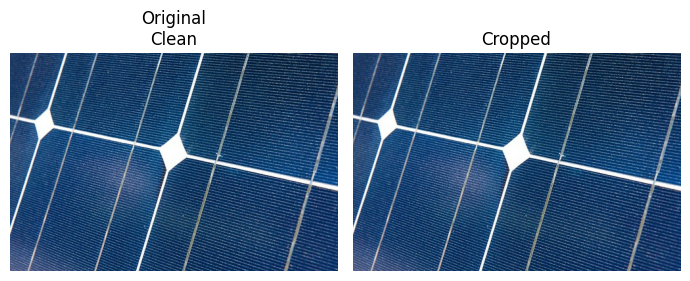

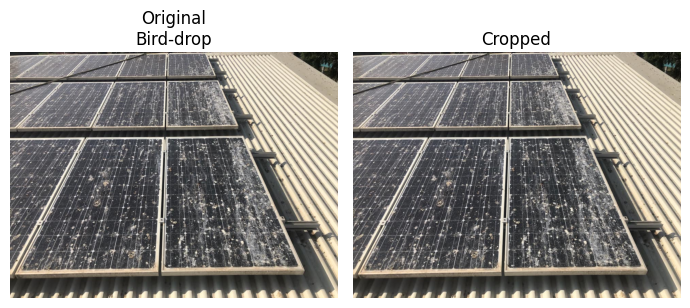

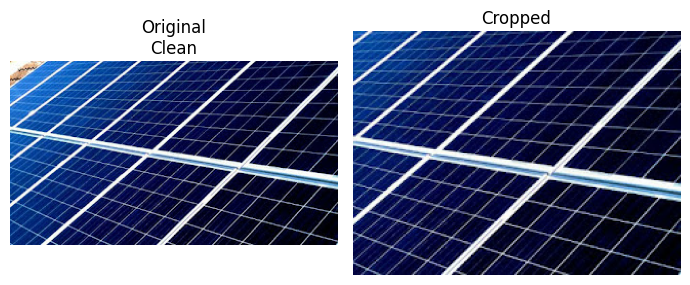

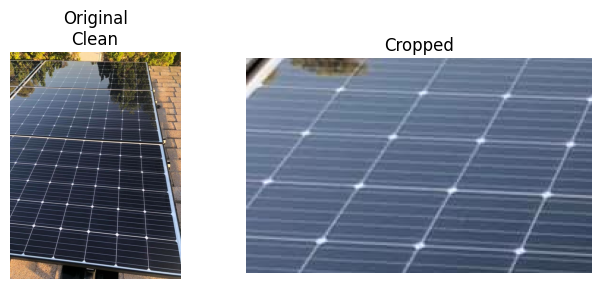

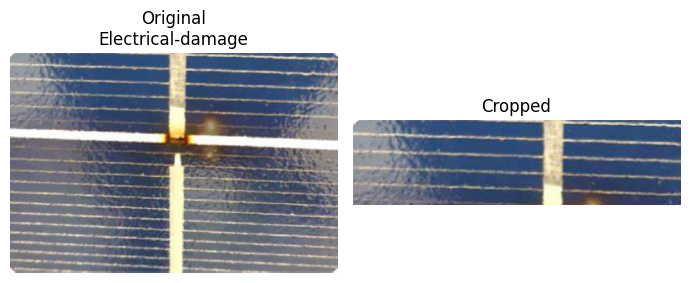

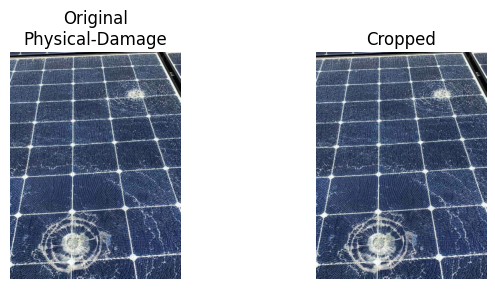

In [18]:
CSV_MASKED  = OUT_ROOT / "splits_localized_masked.csv"
CSV_CROPPED = OUT_ROOT / "splits_localized_cropped.csv"

# pick which exported CSV to preview
show_mode = "cropped"  # cropped or "masked"
csv_show = CSV_MASKED if show_mode == "masked" else CSV_CROPPED

# load original & exported CSVs
try:
    df_orig = pd.read_csv(CLS_CSV, sep=';')         # columns: split, filepath, label
except: 
    df_orig = pd.read_csv(CLS_CSV, sep=',')
df_show = pd.read_csv(csv_show)        # columns: split, filepath, label

# build a fast lookup: (split, label, base) -> original filepath
df_orig = df_orig.copy()
df_orig["base"] = df_orig["filepath"].apply(lambda p: Path(p).stem)
visual_sanity_check(df_orig, df_show, show_mode)



## Classification Task

In [19]:
# Path to your classification CSV
CLS_CSV = "data/classification/localized/splits_localized_cropped.csv"  # change if different

# Train *all* available classifiers from the repo
MODELS = [
    "cnn_plain",
    "mobilenetv3",
    "densenet",
    "vgg16",
    "vgg19",
    "resnet50",
    "inceptionv3_base",
    "inceptionv3_net_proposed",   # the "proposed" head (InceptionV3 backbone)
]

# Shared hyperparams
IMG    = 256
BATCH  = 32
EPOCHS = 30

# Where to dump all runs + summary
RUNS_ROOT = Path("reports/cls_runs")
RUNS_ROOT.mkdir(parents=True, exist_ok=True)

# Environment knobs (helps avoid GPU OOM & spam)
BASE_ENV = os.environ.copy()
BASE_ENV["TF_CPP_MIN_LOG_LEVEL"] = "2"                 # quiet TF logs
BASE_ENV["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"         # let TF grow GPU memory gradually

## Train and Evaluate ALL classifier models and build a summary table

### Helper Functions

In [21]:
results = []
failures = []

for m in MODELS:
    status, run_dir, metrics, err_tail = run_training_and_eval(
        model_name=m,
        csv_path=CLS_CSV,
        img=IMG,
        batch=BATCH,
        epochs=EPOCHS,
        runs_root=RUNS_ROOT,
        base_env=BASE_ENV
    )
    row = {
        "model": m,
        "status": status,
        "run_dir": run_dir,
        "acc": None,
        "macro_f1": None,
        "support": None,
    }
    if metrics:
        # Try to pull common fields; fall back gracefully if keys differ in your eval script
        row["acc"] = metrics.get("accuracy") or metrics.get("test_accuracy") or metrics.get("acc")
        row["macro_f1"] = metrics.get("macro_f1") or metrics.get("f1_macro")
        row["support"] = metrics.get("test_support") or metrics.get("n_test")
    else:
        if status != "OK":
            failures.append((m, status, err_tail))

    results.append(row)

summary_df = pd.DataFrame(results).sort_values(by=["status","acc"], ascending=[True, False])
display(summary_df)

# Save summary
summary_csv = RUNS_ROOT / "summary.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved summary ->", summary_csv)

if failures:
    print("\nSome models failed:")
    for m, st, err in failures:
        print(f"\n[{m}] {st}\n{err}")



=== Training cnn_plain ===
$ c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.cls.train_cls --csv data/classification/localized/splits_localized_cropped.csv --model_name cnn_plain --out reports\cls_runs\cnn_plain --epochs 30 --batch 32 --img 256
---- TRAIN STDOUT (tail) ----
 7703 - val_accuracy: 0.2674
Epoch 12/30

17/17 [==============================] - 4s 221ms/step - loss: 1.5981 - accuracy: 0.3473 - val_loss: 1.7829 - val_accuracy: 0.2500

---- TRAIN STDERR (tail) ----
 

=== Evaluating cnn_plain ===
$ c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\python.exe -m src.cls.eval_cls --csv data/classification/localized/splits_localized_cropped.csv --model reports\cls_runs\cnn_plain\best.keras --out reports\cls_runs\cnn_plain\eval --img 256
---- TRAIN STDOUT (tail) ----
 7703 - val_accuracy: 0.2674
Epoch 12/30

17/17 [==============================] - 4s 221ms/step - loss: 1.5981 - accuracy: 0.3473 - val_loss: 1.7829 - val_accuracy: 0.2500

---- TRAIN STDERR 

,model,status,run_dir,acc,macro_f1,support
0,cnn_plain,EVAL_FAIL,reports\cls_runs\cnn_plain,None,None,None
1,mobilenetv3,EVAL_FAIL,reports\cls_runs\mobilenetv3,None,None,None
2,densenet,EVAL_FAIL,reports\cls_runs\densenet,None,None,None
3,vgg16,EVAL_FAIL,reports\cls_runs\vgg16,None,None,None
4,vgg19,EVAL_FAIL,reports\cls_runs\vgg19,None,None,None
5,resnet50,EVAL_FAIL,reports\cls_runs\resnet50,None,None,None
6,inceptionv3_base,EVAL_FAIL,reports\cls_runs\inceptionv3_base,None,None,None
7,inceptionv3_net_proposed,EVAL_FAIL,reports\cls_runs\inceptionv3_net_proposed,None,None,None


Saved summary -> reports\cls_runs\summary.csv

Some models failed:

[cnn_plain] EVAL_FAIL
Traceback (most recent call last):
  File "c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'label'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Gaming Rig\anaconda3\envs\deeplearning_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Gaming 

# View the Performance Metrics for Each Model

## Vanilla CNN Classification Model

In [23]:
PER_CLASS_JSON = "reports/cls_runs/cnn_plain/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/cnn_plain/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.314917
     macro_precision: 0.157977
        macro_recall: 0.238400
            macro_f1: 0.165039
  weighted_precision: 0.183482
     weighted_recall: 0.314917
         weighted_f1: 0.211456
   balanced_accuracy: 0.238400
         num_classes: 6
        test_support: 181

Classes with zero recall (no correct predictions): ['Clean', 'Physical-Damage', 'Snow-Covered']

Wrote overall metrics -> reports/cls_runs/cnn_plain/eval/test_metrics_full.json


## Densenet Calssification Model

In [24]:
PER_CLASS_JSON = "reports/cls_runs/densenet/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/densenet/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.839779
     macro_precision: 0.860459
        macro_recall: 0.822503
            macro_f1: 0.829014
  weighted_precision: 0.856794
     weighted_recall: 0.839779
         weighted_f1: 0.838998
   balanced_accuracy: 0.822503
         num_classes: 6
        test_support: 181

Wrote overall metrics -> reports/cls_runs/densenet/eval/test_metrics_full.json


## InceptionV3 Net Base Classification Model

In [25]:
PER_CLASS_JSON = "reports/cls_runs/inceptionv3_base/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/inceptionv3_base/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.524862
     macro_precision: 0.526223
        macro_recall: 0.499304
            macro_f1: 0.493531
  weighted_precision: 0.523823
     weighted_recall: 0.524862
         weighted_f1: 0.514255
   balanced_accuracy: 0.499304
         num_classes: 6
        test_support: 181

Wrote overall metrics -> reports/cls_runs/inceptionv3_base/eval/test_metrics_full.json


## InceptionV3 Net Proposed Classification Model

In [26]:
PER_CLASS_JSON = "reports/cls_runs/inceptionv3_net_proposed/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/inceptionv3_net_proposed/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.701657
     macro_precision: 0.707023
        macro_recall: 0.696557
            macro_f1: 0.688814
  weighted_precision: 0.721546
     weighted_recall: 0.701657
         weighted_f1: 0.697727
   balanced_accuracy: 0.696557
         num_classes: 6
        test_support: 181

Wrote overall metrics -> reports/cls_runs/inceptionv3_net_proposed/eval/test_metrics_full.json


## MobileNetV3  Classification Model

In [27]:
PER_CLASS_JSON = "reports/cls_runs/mobilenetv3/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/mobilenetv3/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.381215
     macro_precision: 0.464794
        macro_recall: 0.318999
            macro_f1: 0.312393
  weighted_precision: 0.456349
     weighted_recall: 0.381215
         weighted_f1: 0.351135
   balanced_accuracy: 0.318999
         num_classes: 6
        test_support: 181

Classes with zero recall (no correct predictions): ['Physical-Damage']

Wrote overall metrics -> reports/cls_runs/mobilenetv3/eval/test_metrics_full.json


## ResNet50  Classification Model

In [28]:
PER_CLASS_JSON = "reports/cls_runs/resnet50/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/resnet50/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.303867
     macro_precision: 0.289371
        macro_recall: 0.271026
            macro_f1: 0.234167
  weighted_precision: 0.290792
     weighted_recall: 0.303867
         weighted_f1: 0.241634
   balanced_accuracy: 0.271026
         num_classes: 6
        test_support: 181

Classes with zero recall (no correct predictions): ['Dusty', 'Physical-Damage']

Wrote overall metrics -> reports/cls_runs/resnet50/eval/test_metrics_full.json


## Vgg16 Classification Model

In [29]:
PER_CLASS_JSON = "reports/cls_runs/vgg16/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/vgg16/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.668508
     macro_precision: 0.733377
        macro_recall: 0.678388
            macro_f1: 0.673386
  weighted_precision: 0.741223
     weighted_recall: 0.668508
         weighted_f1: 0.662198
   balanced_accuracy: 0.678388
         num_classes: 6
        test_support: 181

Wrote overall metrics -> reports/cls_runs/vgg16/eval/test_metrics_full.json


## Vgg19 Classification Model

In [30]:
PER_CLASS_JSON = "reports/cls_runs/vgg19/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/vgg19/eval/test_metrics_full.json"
if __name__ == "__main__":
    main(PER_CLASS_JSON, OUT_JSON)

Overall test metrics:
            accuracy: 0.651934
     macro_precision: 0.689898
        macro_recall: 0.653834
            macro_f1: 0.658459
  weighted_precision: 0.690549
     weighted_recall: 0.651934
         weighted_f1: 0.658959
   balanced_accuracy: 0.653834
         num_classes: 6
        test_support: 181

Wrote overall metrics -> reports/cls_runs/vgg19/eval/test_metrics_full.json


In [31]:
# =========================================
# Kaggle → Baseline → Export → Masked/Cropped → Compare
# =========================================

# ----- CONFIG (EDIT THESE) -----
KAGGLE_ROOT = "data/classification/images"     # folder containing class subfolders from Kaggle dataset
SEG_MODEL   = "reports/seg_unet/best.keras"  # your trained U-Net path
RUN_DIR     = "reports/cls_kaggle_incv3"     # where models & logs go

# Image sizes
IMG_CLS     = 299    # InceptionV3 default (use 299)
IMG_SEG     = 256    # U-Net inference size for export (384–256 is good)

VAL_FRAC, TEST_FRAC = 0.2, 0.2
BATCH      = 32
SEED       = 7

# Exporter thresholds
THRESH_MODE = "otsu"   # "otsu" (needs OpenCV) or "fixed"
THRESH      = 0.50
MIN_AREA    = 1500
DILATE_PX   = 4
CLOSE_PX    = 5
PAD         = 16
OUT_LOCALIZED = "data/classification/localized"  # where masked/cropped + CSVs get written

# --------------------------------
import os, re, random, json, math, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict

import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Optional: OpenCV for nicer masks & oriented crops
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

# Seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Path(RUN_DIR).mkdir(parents=True, exist_ok=True)
Path(OUT_LOCALIZED).mkdir(parents=True, exist_ok=True)

# =============== 1) Build Kaggle CSV splits ===============
CSV_BASE = "data/classification/splits_spfnet_kaggle.csv"
root = Path(KAGGLE_ROOT)

def norm_label(s: str) -> str:
    s = s.strip().replace(" ", "-")
    s = re.sub(r"[_]+","-", s)
    mapping = {
        "Bird-drop":"Bird-drop","Bird-Drop":"Bird-drop",
        "Clean":"Clean",
        "Dusty":"Dusty",
        "Electrical-damage":"Electrical-damage","Electrical-Damage":"Electrical-damage",
        "Physical-Damage":"Physical-Damage","Physical-damage":"Physical-Damage",
        "Snow-Covered":"Snow-Covered","Snow-covered":"Snow-Covered",
    }
    return mapping.get(s, s)

rows = []
classes = [p.name for p in root.iterdir() if p.is_dir()]
for c in sorted(classes):
    label = norm_label(c)
    files = [p for p in (root/c).glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}]
    random.shuffle(files)
    n = len(files); n_val = int(round(n*VAL_FRAC)); n_test = int(round(n*TEST_FRAC))
    val = set(files[:n_val]); test = set(files[n_val:n_val+n_test])
    for p in files:
        split = "train"
        if p in val: split = "val"
        elif p in test: split = "test"
        rows.append((split, str(p), label))

df_base = pd.DataFrame(rows, columns=["split","filepath","label"])
Path(CSV_BASE).parent.mkdir(parents=True, exist_ok=True)
df_base.to_csv(CSV_BASE, index=False)
print(f"[splits] Wrote: {CSV_BASE}")
print(df_base["label"].value_counts())

# =============== 2) Data pipeline (TFDS) ===============
def build_label_maps(csv_path):
    df = pd.read_csv(csv_path)
    classes = sorted(df["label"].unique())
    class_to_id = {c:i for i,c in enumerate(classes)}
    return df, classes, class_to_id

def ds_from_csv(csv_path, split, img=299, batch=32, class_to_id=None, one_hot=False, augment=True):
    df = pd.read_csv(csv_path)
    sub = df[df["split"] == split].copy()
    if class_to_id is None:
        classes = sorted(sub["label"].unique())
        class_to_id = {c:i for i,c in enumerate(classes)}
    y = sub["label"].map(class_to_id).astype(np.int32).values
    x = sub["filepath"].values
    ds = tf.data.Dataset.from_tensor_slices((x,y))

    def _parse(p,y):
        b  = tf.io.read_file(p)
        im = tf.image.decode_image(b, channels=3, expand_animations=False)
        im = tf.image.resize(im, (img,img))
        im = tf.cast(im, tf.float32)            # still 0..255
        im = preprocess_input(im)               # InceptionV3 preprocessing
        if augment and split=="train":
            im = tf.image.random_flip_left_right(im)
            im = tf.image.random_contrast(im, 0.9, 1.1)
        y  = tf.cast(y, tf.int32)
        if one_hot:
            y = tf.one_hot(y, depth=len(class_to_id), dtype=tf.float32)
        return im, y

    ds = ds.map(_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(min(len(x), 2000), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# =============== 3) Model builder (InceptionV3) ===============
def build_incv3(num_classes, lr=1e-4, train_backbone=False, input_shape=(IMG_CLS, IMG_CLS, 3)):
    base = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = train_backbone
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.30)(x)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(base.input, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base

# =============== 4) Train (warm-up + fine-tune) ===============
def train_incv3(csv_path, run_tag):
    df, classes, class_to_id = build_label_maps(csv_path)
    nC = len(classes)

    train_ds = ds_from_csv(csv_path, "train", img=IMG_CLS, batch=BATCH,
                           class_to_id=class_to_id, one_hot=False, augment=True)
    val_ds   = ds_from_csv(csv_path, "val",   img=IMG_CLS, batch=BATCH,
                           class_to_id=class_to_id, one_hot=False, augment=False)

    y_train = df[df.split=="train"]["label"].map(class_to_id).values
    cw = compute_class_weight("balanced", classes=np.arange(nC), y=y_train)
    class_weights = {i: float(w) for i,w in enumerate(cw)}

    model, base = build_incv3(num_classes=nC, lr=1e-4, train_backbone=False)
    ckpt_warm = Path(RUN_DIR) / f"{run_tag}_best_warm.keras"
    cb = [
        tf.keras.callbacks.ModelCheckpoint(str(ckpt_warm), save_best_only=True,
                                           monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
                                         monitor="val_accuracy", mode="max"),
    ]
    print(f"[train] Warm-up ({run_tag})...")
    model.fit(train_ds, validation_data=val_ds, epochs=5,
              class_weight=class_weights, callbacks=cb, verbose=1)

    # Fine-tune last ~60 layers (freeze BN)
    for layer in base.layers[:-60]:
        layer.trainable = False
    for layer in base.layers[-60:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    ckpt = Path(RUN_DIR) / f"{run_tag}_best.keras"
    cb2 = [
        tf.keras.callbacks.ModelCheckpoint(str(ckpt), save_best_only=True,
                                           monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True,
                                         monitor="val_accuracy", mode="max"),
    ]
    print(f"[train] Fine-tune ({run_tag})...")
    model.fit(train_ds, validation_data=val_ds, epochs=20,
              class_weight=class_weights, callbacks=cb2, verbose=1)

    return classes, class_to_id, str(ckpt)

# =============== 5) Evaluate helper ===============
def eval_on_test(csv_path, classes, class_to_id, model_path):
    test_ds = ds_from_csv(csv_path, "test", img=IMG_CLS, batch=BATCH,
                          class_to_id=class_to_id, one_hot=False, augment=False)
    # collect y_true and y_pred
    y_true, y_pred = [], []
    model = tf.keras.models.load_model(model_path, compile=False)
    for xb, yb in test_ds:
        probs = model.predict(xb, verbose=0)
        y_true.append(yb.numpy())
        y_pred.append(np.argmax(probs, axis=1))
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, supp = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(classes))), zero_division=0
    )
    macro_f1 = np.mean(f1)
    weighted_f1 = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)[2]
    report = classification_report(y_true, y_pred, target_names=classes, zero_division=0, digits=3)
    return {"accuracy": acc, "macro_f1": macro_f1, "weighted_f1": weighted_f1, "report": report}

# =============== 6) Minimal exporter (letterbox, clean mask, mask/crop, write CSVs) ===============
def decode_rgb(path: str) -> np.ndarray:
    b = tf.io.read_file(path)
    x = tf.image.decode_image(b, channels=3, expand_animations=False)
    return (tf.cast(x, tf.float32) / 255.0).numpy()

def letterbox(img01: np.ndarray, size: int, pad_val: float=0.0):
    H, W, _ = img01.shape
    s = min(size / H, size / W)
    newH, newW = int(round(H*s)), int(round(W*s))
    img_res = tf.image.resize(img01, (newH, newW), method="bilinear").numpy()
    pad_y, pad_x = size - newH, size - newW
    top, left = pad_y//2, pad_x//2
    img_sq = np.ones((size,size,3), dtype=np.float32)*pad_val
    img_sq[top:top+newH, left:left+newW] = img_res
    return img_sq, (top,left), (newH,newW)

def unletterbox_mask(mask_sq: np.ndarray, orig_hw, pad, newHW):
    H0, W0 = orig_hw
    top, left = pad
    newH, newW = newHW
    crop = mask_sq[top:top+newH, left:left+newW]
    mask = tf.image.resize(crop[...,None], (H0,W0), method="nearest").numpy()[...,0]
    return mask

def infer_prob(seg_model, img01: np.ndarray, size: int):
    (H0,W0,_) = img01.shape
    img_sq, pad, newHW = letterbox(img01, size, 0.0)
    prob_sq = seg_model(tf.expand_dims(img_sq,0), training=False).numpy()[0]
    if prob_sq.ndim == 3: prob_sq = prob_sq[...,0]
    return unletterbox_mask(prob_sq, (H0,W0), pad, newHW)

def threshold_prob(prob: np.ndarray, thr: float, mode: str):
    p = prob.copy()
    if HAS_CV2:
        p = cv2.GaussianBlur(p, (0,0), sigmaX=1.0)
    if mode.lower()=="otsu" and HAS_CV2:
        p8 = (np.clip(p,0,1)*255).astype(np.uint8)
        _, m = cv2.threshold(p8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return (m>0).astype(np.uint8)
    return (p >= thr).astype(np.uint8)

def polish_mask(mbin: np.ndarray, min_area=MIN_AREA, close_px=CLOSE_PX, dilate_px=DILATE_PX):
    m = mbin.astype(np.uint8)
    if HAS_CV2:
        n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
        keep = np.zeros_like(m)
        for i in range(1,n):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                keep[labels==i] = 1
        m = keep
        if close_px>0:
            k = np.ones((close_px, close_px), np.uint8)
            m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
        if dilate_px>0:
            k = np.ones((dilate_px, dilate_px), np.uint8)
            m = cv2.dilate(m, k, iterations=1)
    return m

def apply_mask(img01: np.ndarray, prob: np.ndarray, thr=THRESH):
    m = (prob >= thr).astype(np.uint8)
    img_u8 = (np.clip(img01,0,1)*255).astype(np.uint8)
    masked = img_u8.copy()
    masked[m==0] = 0
    return Image.fromarray(masked, "RGB")

def bbox_from_mask(m: np.ndarray, pad=PAD):
    ys, xs = np.where(m>0)
    if len(ys)==0: return None
    y0,y1 = int(ys.min()), int(ys.max())
    x0,x1 = int(xs.min()), int(xs.max())
    return max(0,y0-pad), y1+pad, max(0,x0-pad), x1+pad

def crop_panel(img01: np.ndarray, m: np.ndarray, pad=PAD):
    H,W,_ = img01.shape
    bb = bbox_from_mask(m, pad)
    if bb is None: return None
    y0,y1,x0,x1 = bb
    y1=min(H,y1); x1=min(W,x1)
    crop = (np.clip(img01[y0:y1, x0:x1],0,1)*255).astype(np.uint8)
    return Image.fromarray(crop, "RGB")

def save_image(pil_img: Image.Image, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    if str(path).lower().endswith((".jpg",".jpeg")):
        pil_img.save(str(path), quality=95, subsampling=0, optimize=True)
    else:
        pil_img.save(str(path), compress_level=3)

def run_exporter(csv_in, seg_model_path, out_root=OUT_LOCALIZED,
                 mode="both", img_infer=IMG_SEG, thresh_mode=THRESH_MODE, thresh=THRESH,
                 min_area=MIN_AREA, close_px=CLOSE_PX, dilate_px=DILATE_PX, pad=PAD, ext="png", on_empty="copy"):
    df = pd.read_csv(csv_in)
    out_root = Path(out_root)
    out_mask = out_root / "masked"
    out_crop = out_root / "cropped"
    if mode in ("masked","both"): out_mask.mkdir(parents=True, exist_ok=True)
    if mode in ("cropped","both"): out_crop.mkdir(parents=True, exist_ok=True)

    seg_model = tf.keras.models.load_model(seg_model_path, compile=False)

    rows_mask, rows_crop = [], []
    for split in df["split"].unique():
        for lbl in df[df.split==split]["label"].unique():
            if mode in ("masked","both"): (out_mask/split/lbl).mkdir(parents=True, exist_ok=True)
            if mode in ("cropped","both"): (out_crop/split/lbl).mkdir(parents=True, exist_ok=True)

    for r in df.itertuples(index=False):
        split, img_path, label = r.split, r.filepath, r.label
        try:
            img = decode_rgb(img_path)
        except Exception as e:
            print(f"[export WARN] read fail: {img_path} -> {e}")
            continue
        prob = infer_prob(seg_model, img, img_infer)
        mbin = threshold_prob(prob, thresh, mode=thresh_mode)
        mbin = polish_mask(mbin, min_area=min_area, close_px=close_px, dilate_px=dilate_px)

        base = Path(img_path).stem
        if mode in ("masked","both"):
            masked_img = apply_mask(img, prob, thr=thresh)
            p = out_mask/split/label/f"{base}_masked.{ext}"
            save_image(masked_img, p)
            rows_mask.append((split, str(p), label))
        if mode in ("cropped","both"):
            cropped_img = crop_panel(img, mbin, pad=pad)
            if cropped_img is None:
                if on_empty=="skip":
                    pass
                elif on_empty=="mask_zero":
                    cropped_img = Image.fromarray(np.zeros((8,8,3), np.uint8), "RGB")
                else: # copy
                    cropped_img = Image.fromarray((np.clip(img,0,1)*255).astype(np.uint8), "RGB")
            if cropped_img is not None:
                p = out_crop/split/label/f"{base}_crop.{ext}"
                save_image(cropped_img, p)
                rows_crop.append((split, str(p), label))

    csv_masked  = out_root / "splits_localized_masked.csv"
    csv_cropped = out_root / "splits_localized_cropped.csv"
    if rows_mask:
        pd.DataFrame(rows_mask, columns=["split","filepath","label"]).to_csv(csv_masked, index=False)
        print("[export] wrote:", csv_masked, f"({len(rows_mask)} rows)")
    if rows_crop:
        pd.DataFrame(rows_crop, columns=["split","filepath","label"]).to_csv(csv_cropped, index=False)
        print("[export] wrote:", csv_cropped, f"({len(rows_crop)} rows)")
    return (str(csv_masked) if rows_mask else None,
            str(csv_cropped) if rows_crop else None)

# =============== 7) Train + Evaluate three variants ===============
results = []

# Baseline on Kaggle (no masks)
print("\n==== Training BASELINE (original Kaggle images) ====")
classes_base, map_base, model_base = train_incv3(CSV_BASE, run_tag="base")
res_base = eval_on_test(CSV_BASE, classes_base, map_base, model_base)
results.append(("baseline", res_base))
print(res_base["report"])

# Export masked/cropped with your U-Net (if available)
if Path(SEG_MODEL).exists():
    print("\n==== Exporting localized panels (masked & cropped) ====")
    csv_masked, csv_cropped = run_exporter(CSV_BASE, SEG_MODEL, out_root=OUT_LOCALIZED,
                                           mode="both", img_infer=IMG_SEG, thresh_mode=THRESH_MODE,
                                           thresh=THRESH, min_area=MIN_AREA, close_px=CLOSE_PX,
                                           dilate_px=DILATE_PX, pad=PAD, ext="png", on_empty="copy")
else:
    print(f"[export] Skipped (segmentation model not found at {SEG_MODEL})")
    csv_masked, csv_cropped = None, None

# Masked training
if csv_masked:
    print("\n==== Training on MASKED images ====")
    classes_m, map_m, model_m = train_incv3(csv_masked, run_tag="masked")
    res_m = eval_on_test(csv_masked, classes_m, map_m, model_m)
    results.append(("masked", res_m))
    print(res_m["report"])

# Cropped training
if csv_cropped:
    print("\n==== Training on CROPPED images ====")
    classes_c, map_c, model_c = train_incv3(csv_cropped, run_tag="cropped")
    res_c = eval_on_test(csv_cropped, classes_c, map_c, model_c)
    results.append(("cropped", res_c))
    print(res_c["report"])

# =============== 8) Comparison table ===============
rows = []
for name, res in results:
    rows.append([name, res["accuracy"], res["macro_f1"], res["weighted_f1"]])
cmp_df = pd.DataFrame(rows, columns=["run","accuracy","macro_f1","weighted_f1"]).sort_values("macro_f1", ascending=False)
print("\n===== Comparison (higher is better) =====")
display(cmp_df.style.format({c:"{:.4f}" for c in ["accuracy","macro_f1","weighted_f1"]}))


[splits] Wrote: data/classification/splits_spfnet_kaggle.csv
label
Bird-drop            207
Clean                193
Dusty                190
Snow-Covered         123
Electrical-damage    103
Physical-Damage       69
Name: count, dtype: int64

==== Training BASELINE (original Kaggle images) ====
[train] Warm-up (base)...
Epoch 1/5
[train] Warm-up (base)...
Epoch 1/5
17/17 [==============================] - 9s 222ms/step - loss: 1.8409 - accuracy: 0.1928 - val_loss: 1.7971 - val_accuracy: 0.1910
Epoch 2/5
17/17 [==============================] - 9s 222ms/step - loss: 1.8409 - accuracy: 0.1928 - val_loss: 1.7971 - val_accuracy: 0.1910
Epoch 2/5
17/17 [==============================] - 5s 142ms/step - loss: 1.7761 - accuracy: 0.2401 - val_loss: 1.7301 - val_accuracy: 0.3146
Epoch 3/5
17/17 [==============================] - 5s 142ms/step - loss: 1.7761 - accuracy: 0.2401 - val_loss: 1.7301 - val_accuracy: 0.3146
Epoch 3/5
17/17 [==============================] - 5s 154ms/step - loss: 1.75

C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_14888\3033053118.py:278: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(masked, "RGB")
C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_14888\3033053118.py:346: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  cropped_img = Image.fromarray((np.clip(img,0,1)*255).astype(np.uint8), "RGB")
C:\Users\Gaming Rig\AppData\Local\Temp\ipykernel_14888\3033053118.py:294: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(crop, "RGB")


[export] wrote: data\classification\localized\splits_localized_masked.csv (885 rows)
[export] wrote: data\classification\localized\splits_localized_cropped.csv (885 rows)

==== Training on MASKED images ====
[train] Warm-up (masked)...
Epoch 1/5
[train] Warm-up (masked)...
Epoch 1/5
17/17 [==============================] - 9s 217ms/step - loss: 1.9575 - accuracy: 0.1626 - val_loss: 1.7219 - val_accuracy: 0.2921
Epoch 2/5
17/17 [==============================] - 9s 217ms/step - loss: 1.9575 - accuracy: 0.1626 - val_loss: 1.7219 - val_accuracy: 0.2921
Epoch 2/5
17/17 [==============================] - 4s 146ms/step - loss: 1.8651 - accuracy: 0.2250 - val_loss: 1.7068 - val_accuracy: 0.2978
Epoch 3/5
17/17 [==============================] - 4s 146ms/step - loss: 1.8651 - accuracy: 0.2250 - val_loss: 1.7068 - val_accuracy: 0.2978
Epoch 3/5
17/17 [==============================] - 4s 149ms/step - loss: 1.8287 - accuracy: 0.2250 - val_loss: 1.7023 - val_accuracy: 0.3258
Epoch 4/5
17/17 [====

,run,accuracy,macro_f1,weighted_f1
0,baseline,0.8876,0.8760,0.8870
2,cropped,0.7303,0.7091,0.7295
1,masked,0.4101,0.3355,0.3896


In [32]:
# ============================
# Multi-model trainer 
# ============================
import os, json, math, random, numpy as np, pandas as pd
from pathlib import Path
from typing import Dict, Tuple, Callable, Optional, List

import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

SEED = 7
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

RUN_DIR = "reports/cls_multimodel"
Path(RUN_DIR).mkdir(parents=True, exist_ok=True)

# ---------- Data pipeline (per-model preprocess) ----------
def build_label_maps(csv_path: str):
    df = pd.read_csv(csv_path)
    classes = sorted(df["label"].unique())
    class_to_id = {c:i for i,c in enumerate(classes)}
    return df, classes, class_to_id

def make_ds(csv_path: str, split: str, img_size: int, batch: int,
            class_to_id: Dict[str,int],
            preprocess_fn: Callable[[tf.Tensor], tf.Tensor],
            augment: bool, one_hot: bool=False):
    df = pd.read_csv(csv_path)
    sub = df[df["split"] == split].copy()
    y = sub["label"].map(class_to_id).astype(np.int32).values
    x = sub["filepath"].values
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    def _parse(p, y):
        b = tf.io.read_file(p)
        im = tf.image.decode_image(b, channels=3, expand_animations=False)
        im = tf.image.resize(im, (img_size, img_size))
        im = tf.cast(im, tf.float32)              # 0..255
        im = preprocess_fn(im)                    # per-model
        if augment and split == "train":
            im = tf.image.random_flip_left_right(im)
            im = tf.image.random_contrast(im, 0.9, 1.1)
        y = tf.cast(y, tf.int32)
        if one_hot:
            y = tf.one_hot(y, depth=len(class_to_id), dtype=tf.float32)
        return im, y

    ds = ds.map(_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(min(len(x), 2000), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---------- Custom / generic builders ----------
def _maybe_import_utils():
    se_block = residual_block = None
    try:
        from src.utils.se_block import se_block as _se
        se_block = _se
    except Exception:
        pass
    try:
        from src.utils.residual import residual_block as _rb
        residual_block = _rb
    except Exception:
        pass
    return se_block, residual_block

def build_cnn_plain(num_classes: int, input_size: int = 256, lr: float = 1e-4):
    inputs = layers.Input(shape=(input_size, input_size, 3))
    x = inputs
    for f in [32, 64, 128, 256]:
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, out, name="cnn_plain")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model, None

def build_inceptionv3_proposed(num_classes: int,
                               input_size: int = 299,
                               lr: float = 1e-4):
    """
    InceptionV3 (imagenet, include_top=False) + residual + SE + GAP + MLP head.
    - Assumes upstream dataset pipeline already applies inception_v3.preprocess_input.
    - Compiles with sparse_categorical_crossentropy (integer labels).
    Returns: (model, base_backbone)
    """
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.applications import InceptionV3

    # Optional custom blocks (fallbacks if not available)
    se_block = residual_block = None
    try:
        from src.utils.se_block import se_block as _se
        se_block = _se
    except Exception:
        pass
    try:
        from src.utils.residual import residual_block as _rb
        residual_block = _rb
    except Exception:
        pass

    # Backbone
    base = InceptionV3(include_top=False,
                       weights="imagenet",
                       input_shape=(input_size, input_size, 3))
    base.trainable = False

    # Input & features
    inputs = layers.Input(shape=(input_size, input_size, 3))
    feats = base(inputs, training=False)   # (H/32, W/32, C)

    # Residual/SE head
    x = feats
    if residual_block is not None:
        x = residual_block(x, 256)
    else:
        x = layers.Conv2D(256, 1, use_bias=False, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    if se_block is not None:
        x = se_block(x)

    # GAP + MLP
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, use_bias=False)(x)      # <<< Proper Dense call on x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.30)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs, name="inceptionv3_proposed")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base


def build_keras_app(app_cls, num_classes: int, input_size: int, lr: float = 1e-4, name: str = ""):
    base = app_cls(include_top=False, weights="imagenet", input_shape=(input_size, input_size, 3))
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(base.input, out, name=name or app_cls.__name__.lower())
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model, base

# ---------- Registry (builder, input_size, unfreeze_tail, preprocess_fn, alias list) ----------
from tensorflow.keras.applications import (
    InceptionV3, ResNet50, DenseNet121, VGG16, VGG19
)
from tensorflow.keras.applications import mobilenet_v3
from tensorflow.keras.applications import inception_v3, resnet, densenet, vgg16, vgg19

# MobileNetV3 backbone class (Large)
try:
    from tensorflow.keras.applications import MobileNetV3Large as _MobileNetV3Large
    HAS_MNV3 = True
except Exception:
    HAS_MNV3 = False
    _MobileNetV3Large = None

def _reg_entry(app_cls, pp_mod, default_size, unfreeze):
    return {
        "builder": lambda nC, sz: build_keras_app(app_cls, nC, sz, name=app_cls.__name__.lower()),
        "size": default_size,
        "unfreeze": unfreeze,
        "preprocess": pp_mod.preprocess_input,
    }

MODEL_REGISTRY = {
    # custom
    "cnn_plain": {
        "builder": lambda nC, sz: build_cnn_plain(nC, sz),
        "size": 256, "unfreeze": 0,
        "preprocess": lambda x: (x/127.5) - 1.0  # mimic "tf" scaling
    },
    "inceptionv3_proposed": {
        "builder": lambda nC, sz: build_inceptionv3_proposed(nC, sz),
        "size": 299, "unfreeze": 60,
        "preprocess": inception_v3.preprocess_input
    },
    # built-ins
    "inceptionv3":  _reg_entry(InceptionV3,  inception_v3, 299, 60),
    "resnet50":     _reg_entry(ResNet50,     resnet,       224, 50),
    "densenet":     _reg_entry(DenseNet121,  densenet,     224, 50),  # alias to DenseNet121
    "vgg16":        _reg_entry(VGG16,        vgg16,        224, 50),
    "vgg19":        _reg_entry(VGG19,        vgg19,        224, 50),
}
if HAS_MNV3:
    MODEL_REGISTRY["mobilenetv3"] = {
        "builder": lambda nC, sz: build_keras_app(_MobileNetV3Large, nC, sz, name="mobilenetv3large"),
        "size": 224, "unfreeze": 60,
        "preprocess": mobilenet_v3.preprocess_input,
    }

# map user typos/aliases to keys
ALIASES = {
    "ineptionv3": "inceptionv3",
    "inceptionv3_net_proposed": "inceptionv3_proposed",
    "densenet121": "densenet",
    "mobilenetv3large": "mobilenetv3",
}

def _resolve_key(k: str) -> str:
    k = k.strip().lower()
    return ALIASES.get(k, k)

# ---------- Train / FT / Eval ----------
def train_one(csv_path: str, model_key: str, run_tag: str,
              epochs_warm=5, epochs_ft=20, batch=32, lr_warm=1e-4, lr_ft=1e-5) -> Tuple[str, dict]:
    mk = _resolve_key(model_key)
    assert mk in MODEL_REGISTRY, f"Unknown model: {model_key}"
    spec = MODEL_REGISTRY[mk]

    df, classes, class_to_id = build_label_maps(csv_path)
    nC, img_size = len(classes), spec["size"]
    pp = spec["preprocess"]

    train_ds = make_ds(csv_path, "train", img_size, batch, class_to_id, pp, augment=True, one_hot=False)
    val_ds   = make_ds(csv_path, "val",   img_size, batch, class_to_id, pp, augment=False, one_hot=False)
    test_ds  = make_ds(csv_path, "test",  img_size, batch, class_to_id, pp, augment=False, one_hot=False)

    # class weights
    y_train = df[df.split=="train"]["label"].map(class_to_id).values
    cw = compute_class_weight("balanced", classes=np.arange(nC), y=y_train)
    class_weights = {i: float(w) for i,w in enumerate(cw)}

    # build (frozen backbone)
    model, base = spec["builder"](nC, img_size)

    # ---- helpers to read metrics safely
    def _pick(hist_dict, *names, default=None):
        for k in names:
            if k in hist_dict: return hist_dict[k]
        return default

    # ---- warm-up
    ckpt_warm = Path(RUN_DIR) / f"{run_tag}_{mk}_best_warm.keras"
    cb = [
        tf.keras.callbacks.ModelCheckpoint(str(ckpt_warm), save_best_only=True,
                                           monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
                                         monitor="val_accuracy", mode="max"),
    ]
    print(f"[{mk}] warm-up …")
    model.optimizer.learning_rate = lr_warm
    H_warm = model.fit(train_ds, validation_data=val_ds, epochs=epochs_warm,
                       class_weight=class_weights, callbacks=cb, verbose=1)

    # ---- fine-tune (unfreeze tail; keep BN frozen)
    unfreeze_tail = int(spec["unfreeze"])
    if (base is not None) and (unfreeze_tail > 0):
        for layer in base.layers[:-unfreeze_tail]:
            layer.trainable = False
        for layer in base.layers[-unfreeze_tail:]:
            layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr_ft),
                      loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    ckpt = Path(RUN_DIR) / f"{run_tag}_{mk}_best.keras"
    cb2 = [
        tf.keras.callbacks.ModelCheckpoint(str(ckpt), save_best_only=True,
                                           monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True,
                                         monitor="val_accuracy", mode="max"),
    ]
    print(f"[{mk}] fine-tune …")
    H_ft = model.fit(train_ds, validation_data=val_ds, epochs=epochs_ft,
                     class_weight=class_weights, callbacks=cb2, verbose=1)

    # ---- concatenate curves and compute averages
    acc_w   = _pick(H_warm.history, "accuracy", "acc", default=[])
    vacc_w  = _pick(H_warm.history, "val_accuracy", "val_acc", default=[])
    acc_ft  = _pick(H_ft.history,   "accuracy", "acc", default=[])
    vacc_ft = _pick(H_ft.history,   "val_accuracy", "val_acc", default=[])

    acc_all  = list(acc_w) + list(acc_ft)
    vacc_all = list(vacc_w) + list(vacc_ft)

    avg_train_acc = float(np.mean(acc_all))  if len(acc_all)  else float("nan")
    avg_val_acc   = float(np.mean(vacc_all)) if len(vacc_all) else float("nan")
    best_val_acc  = float(np.max(vacc_all))  if len(vacc_all) else float("nan")

    # ---- save learning curves (optional but handy)
    curves_csv = Path(RUN_DIR) / f"{run_tag}_{mk}_learning_curves.csv"
    pd.DataFrame({
        "epoch": np.arange(1, len(acc_all)+1),
        "train_accuracy": acc_all,
        "val_accuracy":   vacc_all,
    }).to_csv(curves_csv, index=False)

    # ---- evaluate on test
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        probs = model.predict(xb, verbose=0)
        y_true.append(yb.numpy()); y_pred.append(np.argmax(probs, axis=1))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

    acc_test = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(nC)), zero_division=0)
    macro_f1 = float(np.mean(f1))
    weighted_f1 = float(precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)[2])
    report = classification_report(y_true, y_pred, target_names=classes, zero_division=0, digits=3)

    metrics = {
        "accuracy_test": acc_test,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "avg_train_accuracy": avg_train_acc,
        "avg_val_accuracy": avg_val_acc,
        "best_val_accuracy": best_val_acc,
        "report": report,
        "classes": classes,
        "img_size": img_size,
        "curves_csv": str(curves_csv),
    }
    with open(Path(RUN_DIR) / f"{run_tag}_{mk}_test_metrics.json", "w") as f:
        json.dump({k: (v if k!="report" else None) for k,v in metrics.items()}, f, indent=2)
    return str(ckpt), metrics


def train_many(csv_path: str, run_tag: str, model_list: List[str], **train_kwargs) -> pd.DataFrame:
    rows = []
    for mk in model_list:
        print("\n" + "="*72)
        print(f"Training {mk} on {Path(csv_path).name} …")
        print("="*72)
        best_path, m = train_one(csv_path, mk, run_tag, **train_kwargs)
        rows.append([
            run_tag, mk, m["img_size"], 
            m["avg_train_accuracy"], m["avg_val_accuracy"], m["best_val_accuracy"],
            m["accuracy_test"], m["macro_f1"], m["weighted_f1"],
            best_path, m["curves_csv"]
        ])
        print(m["report"])
    df = pd.DataFrame(rows, columns=[
        "run","model","img",
        "avg_train_acc","avg_val_acc","best_val_acc",
        "test_acc","macro_f1","weighted_f1",
        "best_model","curves_csv"
    ])
    return df.sort_values(["run","avg_val_acc"], ascending=[True, False])


# ============================
# Choose models (your exact set)
# ============================
MODEL_LIST = ["cnn_plain","densenet","ineptionv3","inceptionv3_proposed","resnet50","vgg16","vgg19","mobilenetv3"]

# ============================
# Run across datasets (edit paths)
# ============================
CSV_BASE    = "data/classification/splits_spfnet_kaggle.csv"
CSV_MASKED  = "data/classification/localized/splits_localized_masked.csv"
CSV_CROPPED = "data/classification/localized/splits_localized_cropped.csv"

results_all = []

if Path(CSV_BASE).exists():
    df_base = train_many(CSV_BASE, run_tag="kaggle_base", model_list=MODEL_LIST,
                         epochs_warm=5, epochs_ft=20, batch=32, lr_warm=1e-4, lr_ft=1e-5)
    results_all.append(df_base)

if Path(CSV_MASKED).exists():
    df_mask = train_many(CSV_MASKED, run_tag="kaggle_masked", model_list=MODEL_LIST,
                         epochs_warm=5, epochs_ft=20, batch=32, lr_warm=1e-4, lr_ft=1e-5)
    results_all.append(df_mask)

if Path(CSV_CROPPED).exists():
    df_crop = train_many(CSV_CROPPED, run_tag="kaggle_cropped", model_list=MODEL_LIST,
                         epochs_warm=5, epochs_ft=20, batch=32, lr_warm=1e-4, lr_ft=1e-5)
    results_all.append(df_crop)

if results_all:
    summary = pd.concat(results_all, ignore_index=True)
    display(summary.style.format({"accuracy":"{:.4f}","macro_f1":"{:.4f}","weighted_f1":"{:.4f}"}))
else:
    print("No CSVs found. Set CSV_BASE / CSV_MASKED / CSV_CROPPED paths first.")



Training cnn_plain on splits_spfnet_kaggle.csv …
[cnn_plain] warm-up …
Epoch 1/5
[cnn_plain] warm-up …
Epoch 1/5
17/17 [==============================] - 7s 186ms/step - loss: 1.7416 - accuracy: 0.2495 - val_loss: 1.6102 - val_accuracy: 0.3596
Epoch 2/5
17/17 [==============================] - 7s 186ms/step - loss: 1.7416 - accuracy: 0.2495 - val_loss: 1.6102 - val_accuracy: 0.3596
Epoch 2/5
17/17 [==============================] - 4s 134ms/step - loss: 1.5199 - accuracy: 0.3932 - val_loss: 1.4661 - val_accuracy: 0.3652
Epoch 3/5
17/17 [==============================] - 4s 134ms/step - loss: 1.5199 - accuracy: 0.3932 - val_loss: 1.4661 - val_accuracy: 0.3652
Epoch 3/5
17/17 [==============================] - 4s 126ms/step - loss: 1.3775 - accuracy: 0.4631 - val_loss: 1.3309 - val_accuracy: 0.4213
Epoch 4/5
17/17 [==============================] - 4s 126ms/step - loss: 1.3775 - accuracy: 0.4631 - val_loss: 1.3309 - val_accuracy: 0.4213
Epoch 4/5
17/17 [==============================] -

,run,model,img,avg_train_acc,avg_val_acc,best_val_acc,test_acc,macro_f1,weighted_f1,best_model,curves_csv
0,kaggle_base,inceptionv3_proposed,299,0.893686,0.739326,0.820225,0.859551,0.8433,0.8572,reports\cls_multimodel\kaggle_base_inceptionv3_proposed_best.keras,reports\cls_multimodel\kaggle_base_inceptionv3_proposed_learning_curves.csv
1,kaggle_base,ineptionv3,299,0.692129,0.703013,0.859551,0.837079,0.8125,0.8342,reports\cls_multimodel\kaggle_base_inceptionv3_best.keras,reports\cls_multimodel\kaggle_base_inceptionv3_learning_curves.csv
2,kaggle_base,resnet50,224,0.752287,0.680899,0.848315,0.853933,0.8321,0.8511,reports\cls_multimodel\kaggle_base_resnet50_best.keras,reports\cls_multimodel\kaggle_base_resnet50_learning_curves.csv
3,kaggle_base,vgg19,224,0.691040,0.593483,0.786517,0.820225,0.8044,0.8194,reports\cls_multimodel\kaggle_base_vgg19_best.keras,reports\cls_multimodel\kaggle_base_vgg19_learning_curves.csv
4,kaggle_base,vgg16,224,0.657687,0.568820,0.775281,0.775281,0.7536,0.7718,reports\cls_multimodel\kaggle_base_vgg16_best.keras,reports\cls_multimodel\kaggle_base_vgg16_learning_curves.csv
5,kaggle_base,cnn_plain,256,0.715784,0.553933,0.662921,0.662921,0.6175,0.6510,reports\cls_multimodel\kaggle_base_cnn_plain_best.keras,reports\cls_multimodel\kaggle_base_cnn_plain_learning_curves.csv
6,kaggle_base,densenet,224,0.428960,0.518202,0.702247,0.713483,0.6912,0.7073,reports\cls_multimodel\kaggle_base_densenet_best.keras,reports\cls_multimodel\kaggle_base_densenet_learning_curves.csv
7,kaggle_base,mobilenetv3,224,0.381474,0.401798,0.668539,0.691011,0.6969,0.6849,reports\cls_multimodel\kaggle_base_mobilenetv3_best.keras,reports\cls_multimodel\kaggle_base_mobilenetv3_learning_curves.csv
8,kaggle_masked,resnet50,224,0.486531,0.377107,0.426966,0.382022,0.3247,0.3667,reports\cls_multimodel\kaggle_masked_resnet50_best.keras,reports\cls_multimodel\kaggle_masked_resnet50_learning_curves.csv
9,kaggle_masked,ineptionv3,299,0.430673,0.366634,0.432584,0.438202,0.3840,0.4315,reports\cls_multimodel\kaggle_masked_inceptionv3_best.keras,reports\cls_multimodel\kaggle_masked_inceptionv3_learning_curves.csv
